# Submission 2: Denoising Autoencoders
Trains CNN autoencoders to denoise pneumonia images based on [Medical image denoising using convolutional denoising autoencoders](https://arxiv.org/pdf/1608.04667.pdf). Contains 3 CNN autoencoders:
1. Autoencoder for denoising noisy images with lambda = 25
2. Autoencoder for denoising noisy images with lambda = 50
3. Autoencoder for denoising noisy images with lambda = 75

### Import Libraries

In [1]:
from sklearn.model_selection import train_test_split
import os
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import pandas as pd
from io import StringIO
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import torch
from matplotlib import pyplot as plt
from skimage.util import random_noise
import numpy as np

### Load Dataset

In [2]:
original_ds_path = r"datasets/pneumonia"
original_ds_filenames = os.listdir(original_ds_path)

In [3]:
# Dataset of clean (no noise) pneumonia images
class CleanDataset(Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir
        self.img_labels = pd.DataFrame([filename for filename in original_ds_filenames])

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Generate image filepath
        filename = self.img_labels.iloc[idx, 0]
        img_path = self.img_dir + "/" + filename
        
        # Read image and label/filename
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx]
        return image, label

In [4]:
original_ds = CleanDataset(img_dir=original_ds_path)

In [5]:
# Get indices to split data into 80% training and 20% test data
train_filenames, test_filenames = train_test_split(original_ds_filenames, train_size=0.8, random_state=0)

# Generate training and test sets from indices
train_ds = Subset(original_ds, train_filenames)
test_ds = Subset(original_ds, test_filenames)

print(f"Training samples: {len(train_ds)} ({len(train_ds)/len(original_ds)*100}% of data)")
print(f"Test samples: {len(test_ds)} ({len(test_ds)/len(original_ds)*100}% of data)")

Training samples: 1850 (79.98270644185041% of data)
Test samples: 463 (20.01729355814959% of data)


### Generating Noisy Images

In [6]:
# Dataset of noisy pneumonia images
class NoisyDataset(Dataset):
    def __init__(self, img_dir, filenames, noise_lambda):
        self.img_dir = img_dir
        self.filenames = filenames
        self.noise_lambda = noise_lambda
        self.preprocessing = transforms.Resize((64, 64))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Generate image filepath
        filename = self.filenames.iloc[idx, 0]
        img_path = self.img_dir + "/" + filename

        # Read image and label/filename
        clean_img = Image.open(img_path)

        # Apply preprocessing in DAE paper
        clean_img = self.preprocessing(clean_img)

        # Add noise
        to_tensor = transforms.PILToTensor() 
        clean_img_tensor = to_tensor(clean_img).float()

        ######## !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! ADD LAMBDA VALUE TO POISSON NOISE BELOW
        
        noisy_img_tensor = np.random.poisson(clean_img_tensor)
        noisy_img_tensor = np.clip(noisy_img_tensor, 0, 255).astype(np.uint8)
        
        return noisy_img_tensor, clean_img_tensor

In [7]:
# Create 3 sets of noisy images based on the original dataset
noisy25_ds = NoisyDataset(img_dir = original_ds_path,
                          filenames = original_ds.img_labels,
                          noise_lambda = 25)

noisy50_ds = NoisyDataset(img_dir = original_ds_path,
                          filenames = original_ds.img_labels,
                          noise_lambda = 50)

noisy75_ds = NoisyDataset(img_dir = original_ds_path,
                          filenames = original_ds.img_labels,
                          noise_lambda = 75)

In [8]:
# Create dataloaders
loader = DataLoader(noisy75_ds, batch_size=16)

torch.Size([1, 64, 64])
With Noise (Left) vs Without Noise (Right) in noisy dataset with lambda = 75


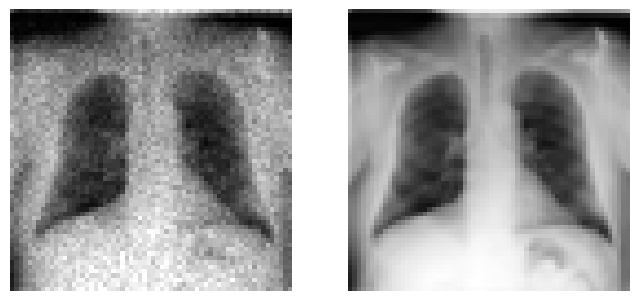

In [9]:
# Display images with and without noise
noisy_imgs, clean_imgs = next(iter(loader))

print(noisy_imgs[0].size())

noisy_img = torch.reshape(noisy_imgs[0], (64, 64, 1))
clean_img = torch.reshape(clean_imgs[0], (64, 64, 1))

imgs = [noisy_img, clean_img]

figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 1
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(imgs[i-1].squeeze(), cmap="grey")

print("With Noise (Left) vs Without Noise (Right) in noisy dataset with lambda = 75")
plt.show()

### Training CNN Autoencoders

In [ ]:
# Train 3 CNN autoencoder models for each set of noisy images (where the input is the noisy image and the ground truth is the normal image).

## Evaluating results

In [ ]:
# Evaluate your results against the test images by running the error term you used in submission 1 against each model compared with the 4 other classical methods. The result should be the average error value for each configuration.

**Why is poisson distribution the ideal one to use to simulate noise for medical images? Why not gaussian or something else? Answer in terms of relevance of medical applications.**

{Answer}

**Which one performed the best? Why do you think this is the case?**

{Answer}